# Field Transformation HMC

## DONE:
 - FT-HMC  implemented for \(8\times8\) \(2D\) QED (using \(\texttt{SiLU}\) activation function).
 - Try to minimize size of the force in training. No significant improvements.
 - Some test on ergodicity (calculate the probability of generating the configs obtained via conventional HMC).
 
## TODO:
  - Plot the force size distribution
  - Is the large force from the original action or the determinant of the Field transformation?
  - If from the determinant, then the fermion force won't cause problems for HMC
  - Use the same field-transformation for larger system (say \(16\times16\), \(32\times32\), \(64\times64\), etc)
  - Study how the \(\delta\mathcal{H}\) depends on the system size (perhaps \(\delta\mathcal{H} = \sqrt{V}\))
  - Study the autocorrelation for observables, \(\mathcal{Q}, \varphi_{\mu\nu}, \tilde\varphi_{\mu\nu}\), etc.
  - Improving the Field-Transformation to reduce force
 

### Imports

In [1]:
%matplotlib widget

In [2]:
import torch
import math
import sys
import os
from timeit import default_timer as timer
from functools import reduce

project_dir = os.path.abspath('../../')
if project_dir not in sys.path:
    sys.path.append(project_dir)

In [3]:
from utils.param import Param
import utils.qed_helpers as qed
import utils.field_transformation as ft
from utils.plot_helpers import init_live_plot, moving_average, update_plots

## Setup

In [5]:
from utils.param import Param

param = Param(
    beta = 1.5,
    lat = (8, 8),
    tau = 0.3, # 0.3
    nstep = 5, # 3
    # ADJUST ME
    ntraj = 2**6, # 2**16 # 2**10 # 2**15
    nprint = 2,
    seed = 1331
)

In [6]:
torch.manual_seed(param.seed)

torch.set_num_threads(param.nth)
torch.set_num_interop_threads(param.nth_interop)
os.environ["OMP_NUM_THREADS"] = str(param.nth)
os.environ["KMP_BLOCKTIME"] = "0"
os.environ["KMP_SETTINGS"] = "1"
os.environ["KMP_AFFINITY"]= "granularity=fine,verbose,compact,1,0"

torch.set_default_tensor_type(torch.DoubleTensor)

### Define `run` function for running `fthmc`:

In [9]:
import utils.qed_helpers as qed

def run(param, field = None):
    if field is None:
        field = param.initializer()
    with open(param.uniquestr(), "w") as O:
        params = param.summary()
        O.write(params)
        qed.put(params)
        plaq, topo = (qed.action(param, field) / (-param.beta*param.volume), qed.topo_charge(field))
        status = f"Initial configuration:  plaq: {plaq}  topo: {topo}\n"
        O.write(status)
        qed.put(status)
        ts = []
        for n in range(param.nrun):
            t = -timer()
            for i in range(param.ntraj):
                dH, exp_mdH, acc, field = qed.hmc(param, field)
                plaq = qed.action(param, field) / (-param.beta * param.volume)
                topo = qed.topo_charge(field)
                #dH, exp_mdH, acc, field = hmc(param, field)
                #plaq = action(param, field) / (-param.beta*param.volume)
                #topo = topocharge(field)
                ifacc = "ACCEPT" if acc else "REJECT"
                status = (f"Traj: {n*param.ntraj+i+1:4}  {ifacc}:  dH: {dH:< 12.8}  "
                          f"exp(-dH): {exp_mdH:< 12.8}  plaq: {plaq:< 12.8}  topo: {topo:< 3.3}\n")
                O.write(status)
                if (i+1) % (param.ntraj//param.nprint) == 0:
                    qed.put(status)
            t += timer()
            ts.append(t)
        print("Run times: ", ts)
        print("Per trajectory: ", [t/param.ntraj for t in ts])
        
    return field

## Generate `field` via `run` method above using `Param` :

In [10]:
field = run(param)

latsize=(8, 8), volume=64, beta=1.5, trajs=64, tau=0.3, steps=5, seed=1331, nth=2, nth_interop=2
Initial configuration:  plaq: 0.15915494309189535  topo: 0.0
plaq(x): 0.1592, force.norm 0.07112
plaq(x): 0.1569, force.norm 0.7031
plaq(x): 0.1549, force.norm 0.9558
plaq(x): 0.1528, force.norm 1.162
plaq(x): 0.1503, force.norm 1.395
plaq(x): 0.1488, force.norm 1.481
plaq(x): 0.1469, force.norm 1.599
plaq(x): 0.1469, force.norm 1.581
plaq(x): 0.146, force.norm 1.618
plaq(x): 0.1456, force.norm 1.677
plaq(x): 0.144, force.norm 1.767
plaq(x): 0.1421, force.norm 1.826
plaq(x): 0.1395, force.norm 1.913
plaq(x): 0.1395, force.norm 1.827
plaq(x): 0.1412, force.norm 1.669
plaq(x): 0.1391, force.norm 1.689
plaq(x): 0.1376, force.norm 1.707
plaq(x): 0.1376, force.norm 1.72
plaq(x): 0.1348, force.norm 1.887
plaq(x): 0.1338, force.norm 1.862
plaq(x): 0.1328, force.norm 1.94
plaq(x): 0.1324, force.norm 1.991
plaq(x): 0.1324, force.norm 1.98
plaq(x): 0.1323, force.norm 1.986
plaq(x): 0.1306, force.norm

plaq(x): 0.05404, force.norm 2.794
plaq(x): 0.05679, force.norm 2.801
plaq(x): 0.05438, force.norm 2.792
plaq(x): 0.05012, force.norm 2.826
plaq(x): 0.04679, force.norm 2.9
plaq(x): 0.04679, force.norm 2.904
plaq(x): 0.04679, force.norm 2.892
plaq(x): 0.04679, force.norm 2.888
Traj:  224  ACCEPT:  dH:  0.29699632   exp(-dH):  0.74304675   plaq:  0.048885865  topo:  0.0
plaq(x): 0.04889, force.norm 2.85
plaq(x): 0.05268, force.norm 2.854
plaq(x): 0.05323, force.norm 2.884
plaq(x): 0.05636, force.norm 2.921
plaq(x): 0.05571, force.norm 2.881
plaq(x): 0.05924, force.norm 2.854
plaq(x): 0.05924, force.norm 2.847
plaq(x): 0.05924, force.norm 2.852
plaq(x): 0.0564, force.norm 2.912
plaq(x): 0.0564, force.norm 2.928
plaq(x): 0.05667, force.norm 2.976
plaq(x): 0.0558, force.norm 2.938
plaq(x): 0.05718, force.norm 2.944
plaq(x): 0.06054, force.norm 2.951
plaq(x): 0.06005, force.norm 3.013
plaq(x): 0.06005, force.norm 3.019
plaq(x): 0.06201, force.norm 3.039
plaq(x): 0.06328, force.norm 2.993
pl

### Define methods for performing the field transformations

### Define:
 1. `train_step` for a single training step
 2. `flow_train` for training the flow
 3. `flow_eval` for evaluating the flow

In [22]:
from utils.plot_helpers import init_live_plot, update_plots


def train_step(
        model,
        action, # not needed
        optimizer,
        metrics,
        batch_size,
        with_force=False,
        pre_model = None
):
    layers, prior = model['layers'], model['prior']
    optimizer.zero_grad()
    #
    xi = None
    if pre_model != None:
        pre_layers, pre_prior = pre_model['layers'], pre_model['prior']
        pre_xi = pre_prior.sample_n(batch_size)
        x = qed.ft_flow(pre_layers, pre_xi)
        xi = qed.ft_flow_inv(layers, x)
    #
    xi, x, logq = ft.apply_flow_to_prior(prior, layers, batch_size=batch_size, xi=xi)
    logp = action(x)
    ##logp = -action(x)
    #logp = -qed.action(param, x)
    #
    force_size = torch.tensor(0.0)
    dkl = ft.calc_dkl(logp, logq)
    loss = torch.tensor(0.0)
    if with_force:
        assert pre_model != None
        force = qed.ft_force(param, layers, xi, create_graph=True)
        #force = ft_force(param, layers, xi, True)
        force_size = torch.sum(torch.square(force))
        loss = force_size
    else:
        loss = dkl
    #
    loss.backward()
    #
    # minimization target
    # loss mini
    # -> (logq - logp) mini
    # -> (action - logJ) mini
    #
    optimizer.step()
    ess = ft.compute_ess(logp, logq)
    #
    print(ft.grab(loss),
          ft.grab(force_size),
          ft.grab(dkl),
          ft.grab(ess),
          torch.linalg.norm(qed.ft_force(param, layers, xi)))
    #
    metrics['loss'].append(ft.grab(loss))
    metrics['force'].append(ft.grab(force_size))
    metrics['dkl'].append(ft.grab(dkl))
    metrics['logp'].append(ft.grab(logp))
    metrics['logq'].append(ft.grab(logq))
    metrics['ess'].append(ft.grab(ess))

    
# packaged from original ipynb by Xiao-Yong Jin
def flow_train(
        param: Param,
        with_force: bool = False,
        pre_model: dict = None,   # pre-model should be a dict defined analogously to `model` defined below
        batch_size: int = 64,
        n_layers: int = 16,
        n_s_nets: int = 2,
        hidden_sizes: list = [8, 8],
        kernel_size: int = 3,
        n_era: int = 10,
        n_epoch: int = 100,
        base_lr: float = 0.001,
        window: int = 15,  # window size in live plot
):
    # Theory
    lattice_shape = param.lat
    link_shape = (2,*param.lat)
    beta = param.beta
    
    # u1_action not needed
    u1_action = ft.U1GaugeAction(beta)
    
    # Model
    prior = ft.MultivariateUniform(torch.zeros(link_shape), 2*np.pi*torch.ones(link_shape))
    #n_layers = 24
    #n_s_nets = 2
    #hidden_sizes = [8,8]
    #kernel_size = 3
    layers = ft.make_u1_equiv_layers(lattice_shape=lattice_shape, n_layers=n_layers, n_mixture_comps=n_s_nets,
                                     hidden_sizes=hidden_sizes, kernel_size=kernel_size)
    ft.set_weights(layers)
    model = {'layers': layers, 'prior': prior}
    # Training
    #base_lr = .001
    
    optimizer = torch.optim.Adam(model['layers'].parameters(), lr=base_lr)
    optimizer_wf = torch.optim.Adam(model['layers'].parameters(), lr=base_lr / 100.0)
    #
    # ADJUST ME
    #N_era = 10
    #N_epoch = 100
    #
    batch_size = batch_size
    print_freq = n_epoch # epochs
    plot_freq = 1 # epochs
    history = {
        'loss' : [],
        'force' : [],
        'dkl' : [],
        'logp' : [],
        'logq' : [],
        'ess' : []
    }
    
    plot_dict = init_live_plot(n_era, n_epoch)
    
    for era in range(n_era):
        for epoch in range(n_epoch):
            #train_step(model, u1_action, optimizer, history, batch_size)
            train_step(model, u1_action, optimizer, history, batch_size)
            if with_force:
                #train_step(model, u1_action, optimizer_wf, history, batch_size,
                train_step(model, u1_action, optimizer_wf, history, batch_size,
                           with_force = with_force, pre_model = pre_model)
            if epoch % print_freq == 0:
                ft.print_metrics(history, print_freq, era, epoch)
                update_plots(history, window=window, **plot_dict)
                # plot_dict['fig'], plot_dict['ax_ess'], plot_dict['ax_loss'],
                # plot_dict['ess_line'], plot_dict['loss_line'], plot_dict['display_id'])
                
    return model, u1_action


def flow_eval(model, action_fn):  # packaged from original ipynb by Xiao-Yong Jin
    ensemble_size = 1024
    u1_ens = ft.make_mcmc_ensemble(model, action_fn, 64, ensemble_size)
    print("Accept rate:", np.mean(u1_ens['accepted']))
    Q = ft.grab(ft.topo_charge(torch.stack(u1_ens['x'], axis=0)))
    X_mean, X_err = ft.bootstrap(Q**2, Nboot=100, binsize=16)
    print(f'Topological susceptibility = {X_mean:.2f} +/- {X_err:.2f}')
    print(f'... vs HMC estimate = 1.23 +/- 0.02')

## Train flow:

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

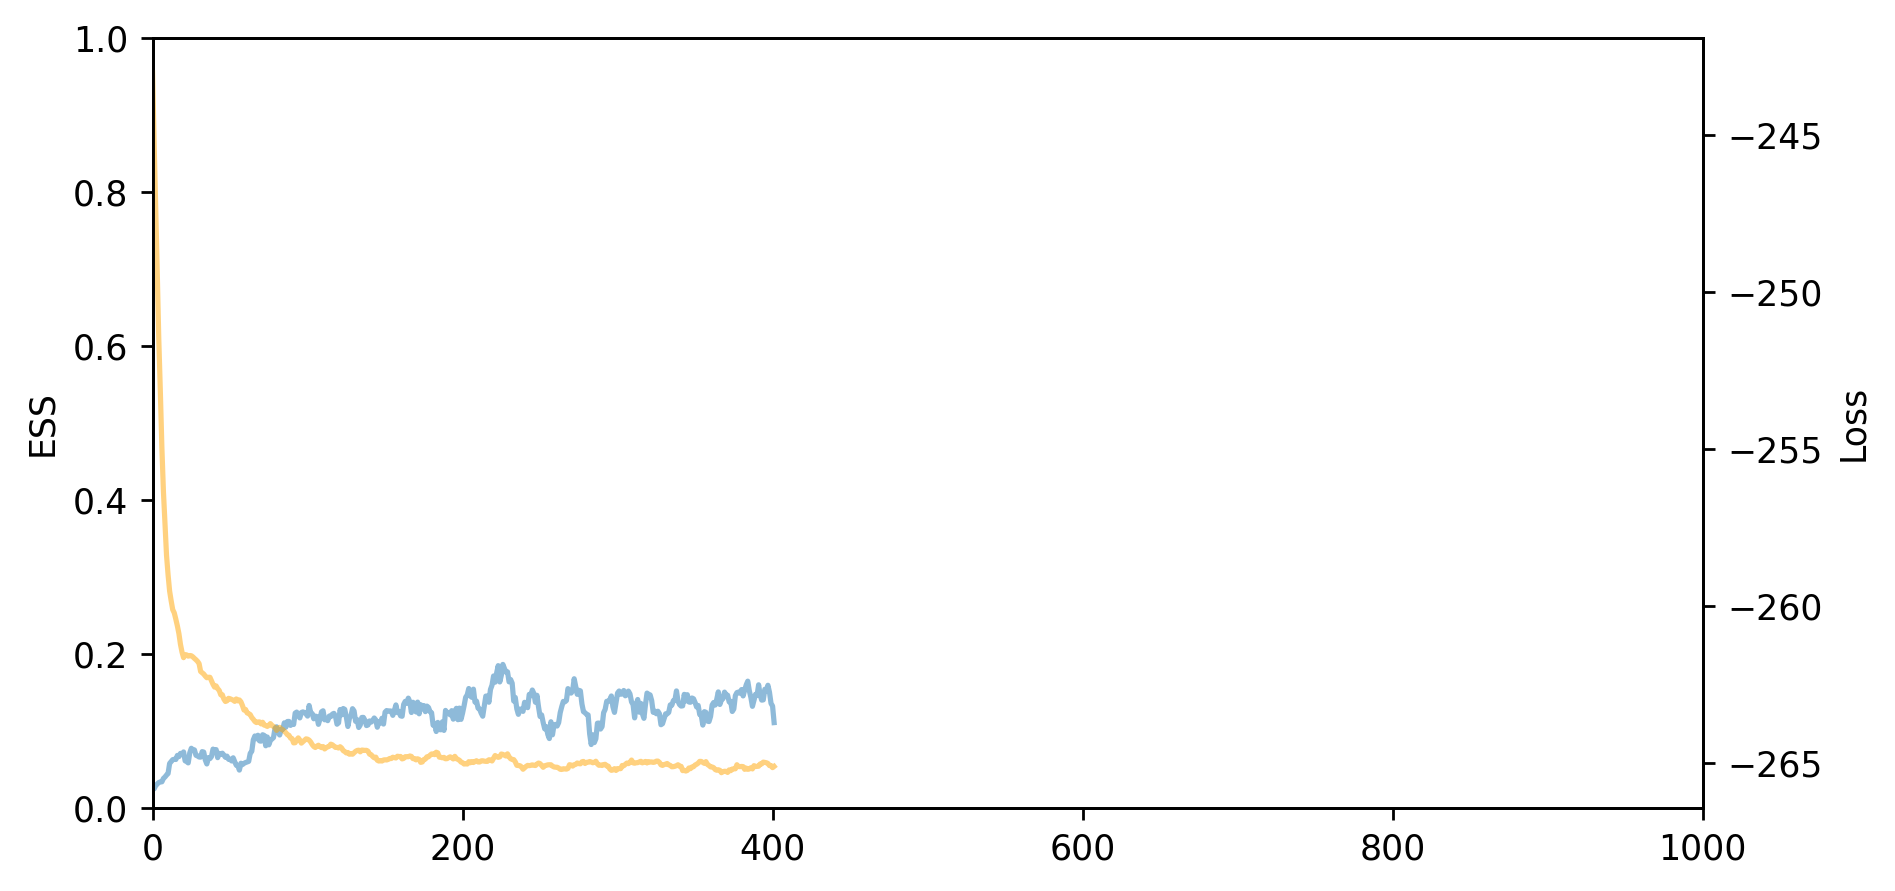

-234.12593006132306 0.0 -234.12593006132306 0.015710709394785097 tensor(138.3033)
== Era 0 | Epoch 0 metrics ==
	loss -234.126
	force 0
	dkl -234.126
	logp -1.12649
	logq -235.252
	ess 0.0157107
-238.59161272096964 0.0 -238.59161272096964 0.0170152461981382 tensor(142.7395)
-237.91121734993288 0.0 -237.91121734993288 0.023171240923507322 tensor(144.1738)
-239.48839636903782 0.0 -239.48839636903782 0.025093723447304993 tensor(148.8323)
-243.63187868496283 0.0 -243.63187868496283 0.02479011891076291 tensor(152.7814)
-241.72484280165978 0.0 -241.72484280165978 0.019144518058616257 tensor(159.5462)
-244.7869615206013 0.0 -244.7869615206013 0.030350103517112276 tensor(166.2658)
-247.88042799520014 0.0 -247.88042799520014 0.02526953397464845 tensor(174.1057)
-248.5886065179279 0.0 -248.5886065179279 0.017573979967062243 tensor(187.4053)
-253.3424756166531 0.0 -253.3424756166531 0.041341104590258124 tensor(200.1005)
-256.43574600348813 0.0 -256.43574600348813 0.021428813151987 tensor(209.3251

-262.8724364138154 0.0 -262.8724364138154 0.04407915822377968 tensor(348.0455)
== Era 9 | Epoch 0 metrics ==
	loss -263.901
	force 0
	dkl -263.901
	logp 48.325
	logq -215.576
	ess 0.0974642
-264.2083511392359 0.0 -264.2083511392359 0.04720869153082698 tensor(327.3375)
-264.3757583093121 0.0 -264.3757583093121 0.09708811008933525 tensor(355.4544)
-264.5548598021375 0.0 -264.5548598021375 0.1618353953940759 tensor(353.9712)
-264.09176961228945 0.0 -264.09176961228945 0.17919959120720153 tensor(362.9880)
-263.86818456496917 0.0 -263.86818456496917 0.09795325480101857 tensor(358.4028)
-264.6762013221623 0.0 -264.6762013221623 0.16132600019728224 tensor(352.9873)
-264.3690361397828 0.0 -264.3690361397828 0.10717327067025907 tensor(353.4732)
-264.79794836892785 0.0 -264.79794836892785 0.08948513073249488 tensor(365.0392)
-264.54807626365664 0.0 -264.54807626365664 0.10218462394114382 tensor(378.3879)
-264.2407023660918 0.0 -264.2407023660918 0.036955580827979194 tensor(364.4106)
== Era 10 | 

-265.090912263346 0.0 -265.090912263346 0.2235412471603574 tensor(372.3919)
== Era 18 | Epoch 0 metrics ==
	loss -264.88
	force 0
	dkl -264.88
	logp 50.906
	logq -213.974
	ess 0.137138
-264.9626205907768 0.0 -264.9626205907768 0.08080202212243409 tensor(377.3563)
-265.29461585977305 0.0 -265.29461585977305 0.24806513550356624 tensor(393.4153)
-264.81314489322443 0.0 -264.81314489322443 0.030084231398031812 tensor(381.6716)
-264.13502539117667 0.0 -264.13502539117667 0.12977335731908196 tensor(374.1644)
-264.4736525341244 0.0 -264.4736525341244 0.08014643231636658 tensor(377.3775)
-264.4221415915092 0.0 -264.4221415915092 0.13807139500579818 tensor(403.3783)
-264.88270648811533 0.0 -264.88270648811533 0.1693119880578144 tensor(366.8573)
-264.3227888707566 0.0 -264.3227888707566 0.027145929442352543 tensor(392.1390)
-264.8699954528362 0.0 -264.8699954528362 0.10647322729689897 tensor(393.7792)
-265.08808588756267 0.0 -265.08808588756267 0.061157844211143834 tensor(361.9489)
== Era 19 | E

-265.09139313803496 0.0 -265.09139313803496 0.06583336784129633 tensor(401.9496)
== Era 27 | Epoch 0 metrics ==
	loss -265.149
	force 0
	dkl -265.149
	logp 51.3873
	logq -213.762
	ess 0.106078
-265.52934833884865 0.0 -265.52934833884865 0.11190211344674342 tensor(399.5839)
-265.2069683349854 0.0 -265.2069683349854 0.2690125516422224 tensor(390.2810)
-265.1383702638864 0.0 -265.1383702638864 0.1734118673469513 tensor(376.2391)
-264.7430012981893 0.0 -264.7430012981893 0.1437924247799215 tensor(376.4808)
-265.25222980965896 0.0 -265.25222980965896 0.07617912268004756 tensor(383.5402)
-265.0414223630162 0.0 -265.0414223630162 0.256746648661359 tensor(396.0945)
-265.1662878848351 0.0 -265.1662878848351 0.2307248480665143 tensor(384.7514)
-264.2219070020151 0.0 -264.2219070020151 0.12225814858480823 tensor(381.4399)
-265.4116550026192 0.0 -265.4116550026192 0.03818433493537199 tensor(398.5972)
-265.413235133346 0.0 -265.413235133346 0.09352570633504798 tensor(396.5807)
== Era 28 | Epoch 0 m

-265.0004306197417 0.0 -265.0004306197417 0.09513411051026494 tensor(404.8794)
== Era 36 | Epoch 0 metrics ==
	loss -265.055
	force 0
	dkl -265.055
	logp 50.9492
	logq -214.105
	ess 0.130747
-265.37031013226965 0.0 -265.37031013226965 0.15154169569127593 tensor(415.8285)
-264.66509105392186 0.0 -264.66509105392186 0.10273460518667682 tensor(399.5598)
-265.20768370068345 0.0 -265.20768370068345 0.09088981687962397 tensor(386.8529)
-265.3086446615663 0.0 -265.3086446615663 0.0783210643313667 tensor(390.5972)
-264.9477527025382 0.0 -264.9477527025382 0.2189990832811248 tensor(391.6200)
-265.0443641770205 0.0 -265.0443641770205 0.0989517608447432 tensor(372.4443)
-265.39353971210966 0.0 -265.39353971210966 0.11848089099878976 tensor(393.3662)
-265.24252998238103 0.0 -265.24252998238103 0.06749374935842307 tensor(390.0689)
-265.20975259762116 0.0 -265.20975259762116 0.16278421357410847 tensor(388.2530)
-265.019338493691 0.0 -265.019338493691 0.24344784194606117 tensor(393.9927)
== Era 37 | 

KeyboardInterrupt: 

In [23]:
n_layers = 8 
n_s_nets = 4
hidden_sizes = [16, 32, 16]
kernel_size = 3
window = 10
n_era = 100
n_epoch = 10

pre_flow_model, pre_flow_action  = flow_train(param, with_force=False, pre_model=None,
                                              n_layers=n_layers, n_s_nets=n_s_nets,
                                              hidden_sizes=hidden_sizes, kernel_size=kernel_size,
                                              n_era=n_era, n_epoch=n_epoch, window=window)

flow_eval(pre_flow_model, pre_flow_action)
pre_flow = pre_flow_model['layers']

In [10]:
train_force = False
flow_model = None

if train_force:
    flow_model, flow_act = flow_train(param, with_force=True, pre_model=pre_flow_model)
else:
    flow_model = pre_flow_model
    
flow_eval(flow_model,flow_act)
flow = flow_model['layers']
# flow.eval()

Accept rate: 0.322265625
Topological susceptibility = 1.15 +/- 0.08
... vs HMC estimate = 1.23 +/- 0.02


In [11]:
def test_force(x = None):
    model = flow_model
    layers, prior = model['layers'], model['prior']
    if x == None:
        pre_model = pre_flow_model
        pre_layers, pre_prior = pre_model['layers'], pre_model['prior']
        pre_xi = pre_prior.sample_n(1)
        x = ft_flow(pre_layers, pre_xi)
    xi = ft_flow_inv(layers, x)
    f = ft_force(param, layers, xi)
    f_s = torch.linalg.norm(f)
    print(f_s)

test_force()
test_force(torch.reshape(field,(1,)+field.shape))

tensor(20.1203)
tensor(10.1375)


In [12]:
field = run(param, field)

latsize = (8, 8)
volume = 64
beta = 2.0
trajs = 2
tau = 2
steps = 8
seed = 1331
nth = 2
nth_interop = 2
Initial configuration:  plaq: 0.6627686419055779  topo: 0.0
plaq(x) 0.6627686419055779  force.norm 20.998065855859632
Traj:    1  ACCEPT:  dH: -0.07537746   exp(-dH):  1.0782911    plaq:  0.64252562   topo: -2.0
plaq(x) 0.6425256187449928  force.norm 20.872768644880754
Traj:    2  ACCEPT:  dH:  0.1301976    exp(-dH):  0.87792193   plaq:  0.60711194   topo:  1.0
plaq(x) 0.607111940547997  force.norm 19.907921445212093
Traj:    3  REJECT:  dH:  0.30832437   exp(-dH):  0.73467697   plaq:  0.60711194   topo:  1.0
plaq(x) 0.607111940547997  force.norm 21.315164809806216
Traj:    4  ACCEPT:  dH:  0.55552569   exp(-dH):  0.57377056   plaq:  0.66056494   topo:  2.0
plaq(x) 0.6605649410769858  force.norm 17.990005167613504
Traj:    5  ACCEPT:  dH:  0.40886075   exp(-dH):  0.66440674   plaq:  0.67927934   topo:  2.0
plaq(x) 0.6792793354321047  force.norm 17.976535887641756
Traj:    6  ACCEPT: 

In [104]:
field = run(param, field)

latsize = (12, 12)
volume = 144
beta = 2.0
trajs = 4
tau = 0.5
steps = 64
seed = 1331
nth = 2
nth_interop = 2
Initial configuration:  plaq: 0.6436154345146917  topo: -1.0
plaq(x) 0.6436154345146917  force.norm 28.595181015284275
Traj:    1  ACCEPT:  dH:  0.00048705497  exp(-dH):  0.99951306   plaq:  0.66561836   topo: -2.0
plaq(x) 0.6656183553517631  force.norm 28.11460650971445
Traj:    2  ACCEPT:  dH: -0.0012323184  exp(-dH):  1.0012331    plaq:  0.62357274   topo: -1.0
plaq(x) 0.6235727353424116  force.norm 30.429344370433586
Traj:    3  ACCEPT:  dH:  0.00029376435  exp(-dH):  0.99970628   plaq:  0.59412058   topo:  0.0
plaq(x) 0.5941205758120947  force.norm 28.538774002763446
Traj:    4  ACCEPT:  dH: -0.00022747014  exp(-dH):  1.0002275    plaq:  0.62219674   topo:  1.0
plaq(x) 0.6221967424532626  force.norm 29.916468389422278
Traj:    5  ACCEPT:  dH:  0.0015577067  exp(-dH):  0.99844351   plaq:  0.69874304   topo:  0.0
plaq(x) 0.6987430410613997  force.norm 27.98159411963013
Traj:

In [ ]:
field.

In [15]:
flows = flow

print(f'plaq(field[0]) {action(param, field[0]) / (-param.beta*param.volume)}')
# field.requires_grad_(True)
x = field
logJ = 0.0
for layer in reversed(flows):
    x, lJ = layer.reverse(x)
    logJ += lJ

# x is the prior distribution now
    
x.requires_grad_(True)
    
y = x
logJy = 0.0
for layer in flows:
    y, lJ = layer.forward(y)
    logJy += lJ
    
s = action(param, y[0]) - logJy

print(logJ,logJy)


# print("eff_action", s + 136.3786)

print("original_action", action(param, y[0]) + 91)

print("eff_action", s + 56)

s.backward()

f = x.grad

x.requires_grad_(False)

print(f'plaq(x) {action(param, x[0]) / (-param.beta*param.volume)}  logJ {logJ}  force.norm {torch.linalg.norm(f)}')

print(f'plaq(y) {action(param, y[0]) / (-param.beta*param.volume)}')

print(f'plaq(x) {action(param, field_run[0]) / (-param.beta*param.volume)}  force.norm {torch.linalg.norm(force(param, field_run[0]))}')


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [16]:
print(x.shape)
x = ft_flow_inv(flow, field_run)
# x = field_run
#for layer in reversed(flows):
#    x, lJ = layer.reverse(x)
ff = ft_force(param, flow, x)
print(torch.linalg.norm(ff))
fff = ft_force(param, flow, x)
print(torch.linalg.norm(fff))

torch.Size([1, 2, 8, 8])
tensor(7.2348)
tensor(7.2348)


In [17]:
x = ft_flow_inv(flow, field_run)
ft_action(param, flow, x)

tensor([-52.6120], grad_fn=<SubBackward0>)

In [18]:
def flattern(l):
    return [x for y in l for x in y]

def average(l):
    return sum(l) / len(l)

def sub_avg(l):
    avg = average(l)
    return np.array([x - avg for x in l])

In [19]:
ft_hmc_info_list = []
def ft_leapfrog(param, flow, x, p):
    mom_norm = torch.sum(p*p)
    info_list = []
    dt = param.dt
    x_ = x + 0.5*dt*p
    f = ft_force(param, flow, x_)
    p_ = p + (-dt)*f
    info = np.array((float(torch.linalg.norm(f)),
                     float(ft_action(param, flow, x_).detach()),
                     float(torch.sum(p*p_)/np.sqrt(mom_norm*torch.sum(p_*p_)))))
    info_list.append(info)
    for i in range(param.nstep-1):
        x_ = x_ + dt*p_
        f = ft_force(param, flow, x_)
        info = np.array((float(torch.linalg.norm(f)),
                        float(ft_action(param, flow, x_).detach()),
                        float(torch.sum(p*p_)/np.sqrt(mom_norm*torch.sum(p_*p_)))))
        info_list.append(info)
        p_ = p_ + (-dt)*f
    x_ = x_ + 0.5*dt*p_
    print(np.sqrt(average([l[0]**2 for l in info_list])),
          (info_list[0][1], info_list[-1][1]),
          info_list[-1][2])
    ft_hmc_info_list.append(info_list)
    return (x_, p_)

def ft_hmc(param, flow, field):
    x = ft_flow_inv(flow, field)
    p = torch.randn_like(x)
    act0 = ft_action(param, flow, x).detach() + 0.5*torch.sum(p*p)
    x_, p_ = ft_leapfrog(param, flow, x, p)
    xr = regularize(x_)
    act = ft_action(param, flow, xr).detach() + 0.5*torch.sum(p_*p_)
    prob = torch.rand([], dtype=torch.float64)
    dH = act-act0
    exp_mdH = torch.exp(-dH)
    acc = prob < exp_mdH
    # ADJUST ME
    newx = xr if acc else x
    # newx = xr
    newfield = ft_flow(flow, newx)
    return (float(dH), float(exp_mdH), acc, newfield)

In [20]:
def ft_run(param, flow, field = None):
    if field == None:
        field = param.initializer()
    ft_hmc_info_list = []
    with open(param.uniquestr(), "w") as O:
        params = param.summary()
        O.write(params)
        put(params)
        plaq, topo = (action(param, field) / (-param.beta*param.volume), topocharge(field))
        status = f"Initial configuration:  plaq: {plaq}  topo: {topo}\n"
        O.write(status)
        put(status)
        ts = []
        for n in range(param.nrun):
            t = -timer()
            for i in range(param.ntraj):
                field_run = torch.reshape(field,(1,)+field.shape)
                dH, exp_mdH, acc, field_run = ft_hmc(param, flow, field_run)
                field = field_run[0]
                plaq = action(param, field) / (-param.beta*param.volume)
                topo = topocharge(field)
                ifacc = "ACCEPT" if acc else "REJECT"
                status = f"Traj: {n*param.ntraj+i+1:4}  {ifacc}:  dH: {dH:< 12.8}  exp(-dH): {exp_mdH:< 12.8}  plaq: {plaq:< 12.8}  topo: {topo:< 3.3}\n"
                O.write(status)
                if (i+1) % (param.ntraj//param.nprint) == 0:
                    put(status)
            t += timer()
            ts.append(t)
        print("Run times: ", ts)
        print("Per trajectory: ", [t/param.ntraj for t in ts])
    return field

In [ ]:
param = Param(
    beta = 2.0,
    lat = (8, 8),
    tau = 0.5, # 0.3
    nstep = 64, # 3
    # ADJUST ME
    ntraj = 4, # 2**16 # 2**10 # 2**15
    nprint = 4,
    #
    seed = 1331)

# field = ft_run(param, pre_flow)
field = ft_run(param, pre_flow, field)

In [22]:
param = Param(
    beta = 2.0,
    lat = (8, 8),
    tau = 0.5, # 0.3
    nstep = 64, # 3
    # ADJUST ME
    ntraj = 4, # 2**16 # 2**10 # 2**15
    nprint = 4,
    #
    seed = 1331)

# field = ft_run(param, pre_flow)
field = ft_run(param, pre_flow, field)

latsize = (8, 8)
volume = 64
beta = 2.0
trajs = 4
tau = 0.5
steps = 64
seed = 1331
nth = 2
nth_interop = 2
Initial configuration:  plaq: 0.7185859884287391  topo: -1.0
35.58825429661411 (-53.64953457231129, -54.05251106745193) 0.957981301570924
Traj:    1  ACCEPT:  dH: -0.2646876    exp(-dH):  1.3030238    plaq:  0.68012964   topo:  0.0
26.996907862728886 (-54.19039581798784, -55.528032313186635) 0.9705934656072241
Traj:    2  ACCEPT:  dH: -0.53375325   exp(-dH):  1.7053208    plaq:  0.72417941   topo:  1.0
27.88171560805188 (-55.551799406136276, -54.5756659006458) 0.9700067180225045
Traj:    3  ACCEPT:  dH: -0.056386845  exp(-dH):  1.0580069    plaq:  0.69634589   topo: -1.0
30.950330945550775 (-54.69092790549618, -52.0511193358186) 0.8944220460873022
Traj:    4  ACCEPT:  dH:  0.49485686   exp(-dH):  0.60965816   plaq:  0.60480921   topo:  1.0
42.92329937977941 (-52.085588556007835, -51.74406041828097) 0.9394773190295843
Traj:    5  ACCEPT:  dH:  1.4368181    exp(-dH):  0.23768285   p

In [23]:
action_list = np.array([l[1] for l in flattern(ft_hmc_info_list)])
action_list = sub_avg(action_list)
np.sqrt(average(action_list**2))

1.389480087367922

In [24]:
force_list = np.array([l[0] for l in flattern(ft_hmc_info_list)])
np.sqrt(average(force_list**2))

26.10260986658055

In [25]:
print(np.array(force_list[0:300]))

[ 18.27711285  34.3038331   38.47971804  22.92079991  14.89793795
  18.08681988  20.31581029  22.14914023  23.87103188  23.34911165
  19.31782271  15.31122775  14.29842581  16.53974364  20.60968096
  22.45969878  19.81038763  14.50076622   9.74271184   7.16144983
   6.43791031   6.51055981   6.79499594   7.1529161    7.57889242
   8.06840814   8.57790798   9.01304499   9.2346246    9.09240327
   8.49076822   7.45884179   6.1723308    4.90264743   3.92519736
   3.41259392   3.33438466   3.51030509   3.78384734   4.08238111
   4.38564792   4.69295284   5.00689449   5.32765208   5.65228937
   5.97601477   6.29380474   6.60160793   6.89683138   7.17811448
   7.44458231   7.69486476   7.92618572   8.13380598   8.31116147
   8.45151134   8.55369476   8.63963128   8.80064034   9.28327141
  10.49678124  12.55137939  14.37275549  13.96333735  11.64322749
   9.55646993   7.99003083   7.13012197   6.80463101   6.76225949
   6.8546393    6.99590927   7.07011514   6.90727963   6.40603871
   5.93640

In [116]:
param_new = Param(
    beta = 2.0,
    lat = (12, 12),
    tau = 0.5, # 0.3
    nstep = 64, # 3
    # ADJUST ME
    ntraj = 4, # 2**16 # 2**10 # 2**15
    nprint = 4,
    #
    seed = 1331)

field_new = run(param_new)

latsize = (12, 12)
volume = 144
beta = 2.0
trajs = 4
tau = 0.5
steps = 64
seed = 1331
nth = 2
nth_interop = 2
Initial configuration:  plaq: 1.0  topo: 0.0
plaq(x) 1.0  force.norm 0.4248460519168721
Traj:    1  ACCEPT:  dH: -0.0067342799  exp(-dH):  1.006757     plaq:  0.80595301   topo:  0.0
plaq(x) 0.805953013227231  force.norm 28.049011264621114
Traj:    2  ACCEPT:  dH: -0.0022364719  exp(-dH):  1.002239     plaq:  0.73310488   topo:  0.0
plaq(x) 0.7331048776426461  force.norm 31.494844115797857
Traj:    3  ACCEPT:  dH:  0.0020860344  exp(-dH):  0.99791614   plaq:  0.73827186   topo:  0.0
plaq(x) 0.7382718552821997  force.norm 26.692062459761768
Traj:    4  ACCEPT:  dH: -0.0015001325  exp(-dH):  1.0015013    plaq:  0.69339233   topo:  1.0
plaq(x) 0.6933923292349193  force.norm 29.713077446867622
Traj:    5  ACCEPT:  dH:  0.0005564365  exp(-dH):  0.99944372   plaq:  0.71896918   topo:  1.0
plaq(x) 0.7189691824534165  force.norm 28.580905275562127
Traj:    6  ACCEPT:  dH: -0.0004101345

In [117]:
def get_nets(layers):
    nets = []
    for l in layers:
        nets.append(l.plaq_coupling.net)
    return nets

In [118]:
def make_u1_equiv_layers_net(*, lattice_shape, nets):
    n_layers = len(nets)
    layers = []
    for i in range(n_layers):
        # periodically loop through all arrangements of maskings
        mu = i % 2
        off = (i//2) % 4
        net = nets[i]
        plaq_coupling = NCPPlaqCouplingLayer(
            net, mask_shape=lattice_shape, mask_mu=mu, mask_off=off)
        link_coupling = GaugeEquivCouplingLayer(
            lattice_shape=lattice_shape, mask_mu=mu, mask_off=off, 
            plaq_coupling=plaq_coupling)
        layers.append(link_coupling)
    return torch.nn.ModuleList(layers)

In [119]:
len(get_nets(flow))

24

In [120]:
flow_new = make_u1_equiv_layers_net(lattice_shape = param_new.lat, nets = get_nets(flow))

In [ ]:
field_new = ft_run(param_new, flow_new)

latsize = (12, 12)
volume = 144
beta = 2.0
trajs = 4
tau = 0.5
steps = 64
seed = 1331
nth = 2
nth_interop = 2
Initial configuration:  plaq: 1.0  topo: 0.0
2.314195897765598 (-123.13420470621207, -123.05803246928448) 0.9989031012080176
Traj:    1  ACCEPT:  dH:  0.014135786  exp(-dH):  0.98596365   plaq:  0.90734321   topo:  0.0
14.58886665162637 (-123.05185793566605, -122.62841151548352) 0.9930968348276462
Traj:    2  ACCEPT:  dH: -0.28390318   exp(-dH):  1.3283043    plaq:  0.83416752   topo:  1.0
22.214461099922524 (-122.62889653566585, -118.53553933362926) 0.9754415909128336
Traj:    3  ACCEPT:  dH:  0.0098759084  exp(-dH):  0.9901727    plaq:  0.74487336   topo:  0.0
17.205793049664383 (-118.45990074846753, -117.48517994354776) 0.9817102721550364
Traj:    4  ACCEPT:  dH:  0.0089591188  exp(-dH):  0.99108089   plaq:  0.73650894   topo:  1.0
31.736732227832498 (-117.32653625484795, -120.15355180970509) 0.9593402002657376
Traj:    5  ACCEPT:  dH: -0.032448851  exp(-dH):  1.0329811    p

In [ ]:
field_new = ft_run(param_new, flow_new, field_new)

In [ ]:
action(param, field)

In [ ]:
action(param_new, field_new)